In [195]:
import numpy as np
import pandas as pd
import scipy

from statsmodels.stats.weightstats import *
from statsmodels.stats.descriptivestats import sign_test
from scipy.stats import chi2_contingency

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [196]:
data = pd.read_csv('credit_card_default_analysis.csv')

In [197]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Task 1

In [198]:
limit0 = data[data['default']==0].LIMIT_BAL
limit1 = data[data['default']==1].LIMIT_BAL

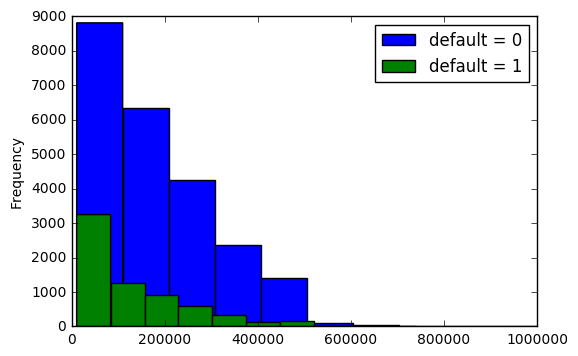

In [199]:
limit0.plot.hist(label='default = 0')
limit1.plot.hist(label='default = 1')
pylab.legend(loc='upper right')
pylab.show()

In [200]:
limit0.describe()

count      23364.000000
mean      178099.726074
std       131628.359660
min        10000.000000
25%        70000.000000
50%       150000.000000
75%       250000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

In [201]:
limit1.describe()

count      6636.000000
mean     130109.656420
std      115378.540571
min       10000.000000
25%       50000.000000
50%       90000.000000
75%      200000.000000
max      740000.000000
Name: LIMIT_BAL, dtype: float64

Проверим гипотезу о равенстве медиан двумя способами: 
        
       а) С помощью доверительного интервала для разности медиан
       б) С помощью непараметрического критерия проверки равенства средних

Построим доверительный интервал для разности медиан в двух выборках:

In [202]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [203]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [204]:
np.random.seed(0)

limit0_median_scores = map(np.median, get_bootstrap_samples(limit0.values, 1000))
limit1_median_scores = map(np.median, get_bootstrap_samples(limit1.values, 1000))

In [205]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(limit1_median_scores, limit0_median_scores))

In [206]:
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [ 60000.  70000.]


Судя по такому доверительному интервалу для медиан, полученному с помощью бутстрепа, видим, что медианы в выборках различаются.

Воспользуемся непараметрическим методом:

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [207]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [208]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [209]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [210]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [211]:
print "p-value: %f" % permutation_test(limit0, limit1, max_permutations = 10000)

p-value: 0.000100


Похоже, что мы также можем отвергнуть гипотезу о равенстве распределений (p_value<0.05) в пользу гипотезы об их неравенстве (со сдвигом)

Данный результат значим с практической точки зрения, так как среднее значение лимита у людей, не выплативших кредит, значительно меньше, чем у людей выплативших его

## Task 2

In [212]:
sex_def0 = data[data['default']==0].SEX
sex_def1 = data[data['default']==1].SEX

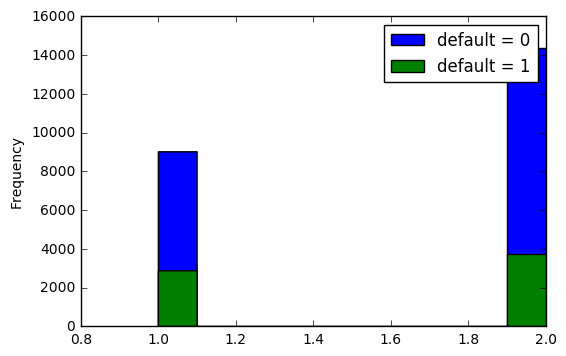

In [213]:
sex_def0.plot.hist(label='default = 0')
sex_def1.plot.hist(label='default = 1')
pylab.legend(loc='upper right')
pylab.show()

Видно, что как и мужчины, так и женщины в бОльшей степени выплачивают кредит. Мужчин (SEX=1) выплативших кредит примерно в два раза больше, чем не выплативших. Женщин выплативших, примерно в 4 раза больше, чем не выплативших.

In [214]:
sex_def0.describe()

count    23364.000000
mean         1.614150
std          0.486806
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: SEX, dtype: float64

In [215]:
sex_def1.describe()

count    6636.000000
mean        1.567058
std         0.495520
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: SEX, dtype: float64

Для проверки гипотезы о том, что гендерный состав группы людей вернувших и не вернувших кредит не отличается ($H_0$) с альтернативой о неравенстве составов ($H_1$) воспользуемся Z-критерием для разности долей для независимых выборок:

In [216]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1 - 1
    p2 = float(sum(sample2)) / n2 - 1
    P = float(p1*n1 + p2*n2) / (n1 + n2) 
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [217]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [218]:
proportions_diff_z_test(proportions_diff_z_stat_ind(sex_def0, sex_def1))

4.4728665216098307e-12

p_value<0.05, следовательно гипотеза о половом равенстве людей выплативших кредиты и не выплативших их отвергается

Построим доверительный интервал для разности долей:

In [219]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1) - 1 
    p2 = float(sum(sample2)) / len(sample2) - 1
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [220]:
proportions_confint_diff_ind(sex_def0, sex_def1)

(0.033634932749628671, 0.060548077974896725)

0 не принадлежит интервалу, значит различия в поле есть

## Task 3

In [221]:
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [222]:
educ0 = data[data['default']==0].EDUCATION
educ1 = data[data['default']==1].EDUCATION

In [223]:
educ0.value_counts()

2    10700
1     8549
3     3680
5      262
4      116
6       43
0       14
Name: EDUCATION, dtype: int64

In [224]:
educ1.value_counts()

2    3330
1    2036
3    1237
5      18
6       8
4       7
Name: EDUCATION, dtype: int64

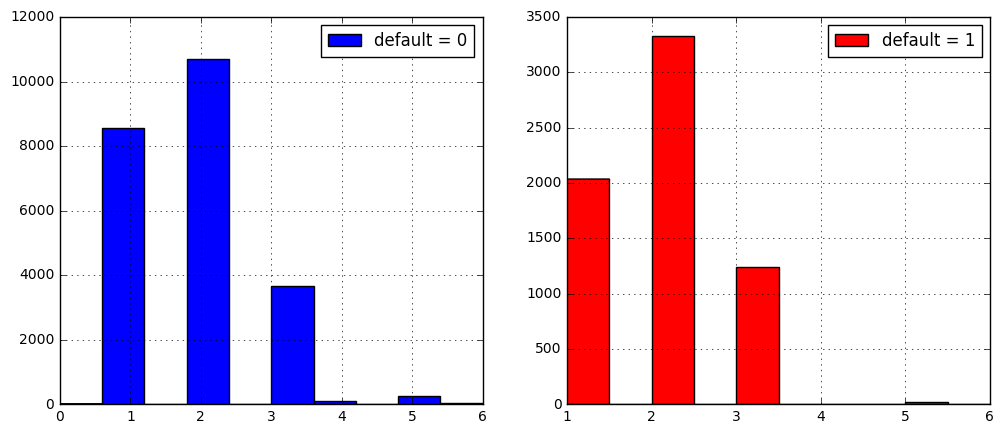

In [225]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
educ0.hist(label='default = 0')
pylab.legend()

pylab.subplot(1,2,2)
educ1.hist(color='red', label='default = 1')
pylab.legend()

По графикам сложно оценить влияние образования на возврат.

In [226]:
educ00 = float(data[(data['default'] == 0) & (data['EDUCATION'] == 0)].shape[0])
educ10 = float(data[(data['default'] == 0) & (data['EDUCATION'] == 1)].shape[0])
educ20 = float(data[(data['default'] == 0) & (data['EDUCATION'] == 2)].shape[0])
educ30 = float(data[(data['default'] == 0) & (data['EDUCATION'] == 3)].shape[0])
educ40 = float(data[(data['default'] == 0) & (data['EDUCATION'] == 4)].shape[0])
educ50 = float(data[(data['default'] == 0) & (data['EDUCATION'] == 5)].shape[0])
educ60 = float(data[(data['default'] == 0) & (data['EDUCATION'] == 6)].shape[0])

educ01 = float(data[(data['default'] == 1) & (data['EDUCATION'] == 0)].shape[0])
educ11 = float(data[(data['default'] == 1) & (data['EDUCATION'] == 1)].shape[0])
educ21 = float(data[(data['default'] == 1) & (data['EDUCATION'] == 2)].shape[0])
educ31 = float(data[(data['default'] == 1) & (data['EDUCATION'] == 3)].shape[0])
educ41 = float(data[(data['default'] == 1) & (data['EDUCATION'] == 4)].shape[0])
educ51 = float(data[(data['default'] == 1) & (data['EDUCATION'] == 5)].shape[0])
educ61 = float(data[(data['default'] == 1) & (data['EDUCATION'] == 6)].shape[0])

In [227]:
M = np.array([[educ00, educ10, educ20, educ30, educ40, educ50, educ60], 
              [educ01, educ11, educ21, educ31, educ41, educ51, educ61]])

In [228]:
M

array([[  1.40000000e+01,   8.54900000e+03,   1.07000000e+04,
          3.68000000e+03,   1.16000000e+02,   2.62000000e+02,
          4.30000000e+01],
       [  0.00000000e+00,   2.03600000e+03,   3.33000000e+03,
          1.23700000e+03,   7.00000000e+00,   1.80000000e+01,
          8.00000000e+00]])

In [229]:
M_diff = [M[0]-M[1]]
M_diff

[array([   14.,  6513.,  7370.,  2443.,   109.,   244.,    35.])]

In [230]:
M_norm = [M[0]/(M[0]+M[1])]

In [231]:
M_norm

[array([ 1.        ,  0.80765234,  0.76265146,  0.74842384,  0.94308943,
         0.93571429,  0.84313725])]

In [232]:
print u"доктор наук:", round(M_norm[0][0],4)
print u"магистр:", round(M_norm[0][1],4)
print u"бакалавр:", round(M_norm[0][2],4)
print u"выпускник школы:", round(M_norm[0][3],4)
print u"начальное образование:", round(M_norm[0][4],4)
print u"прочее:", round(M_norm[0][5],4)
print u"нет данных:", round(M_norm[0][6],4)

доктор наук: 1.0
магистр: 0.8077
бакалавр: 0.7627
выпускник школы: 0.7484
начальное образование: 0.9431
прочее: 0.9357
нет данных: 0.8431


Из полученных данных видно, что доктора наук возвращают все кредиты, в то время как бакалавры и выпускники школ возвращают лишь примерно 75% кредитов.

## Task 4

In [17]:
data.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [184]:
mar00 = float(data[(data['default'] == 0) & (data['MARRIAGE'] == 0)].shape[0])
mar10 = float(data[(data['default'] == 0) & (data['MARRIAGE'] == 1)].shape[0])
mar20 = float(data[(data['default'] == 0) & (data['MARRIAGE'] == 2)].shape[0])
mar30 = float(data[(data['default'] == 0) & (data['MARRIAGE'] == 3)].shape[0])

mar01 = float(data[(data['default'] == 1) & (data['MARRIAGE'] == 0)].shape[0])
mar11 = float(data[(data['default'] == 1) & (data['MARRIAGE'] == 1)].shape[0])
mar21 = float(data[(data['default'] == 1) & (data['MARRIAGE'] == 2)].shape[0])
mar31 = float(data[(data['default'] == 1) & (data['MARRIAGE'] == 3)].shape[0])

In [189]:
mar0 = data[data['default'] == 0].MARRIAGE
mar1 = data[data['default'] == 1].MARRIAGE

In [193]:
mar0.value_counts()

2    12623
1    10453
3      239
0       49
Name: MARRIAGE, dtype: int64

In [194]:
mar1.value_counts()

2    3341
1    3206
3      84
0       5
Name: MARRIAGE, dtype: int64

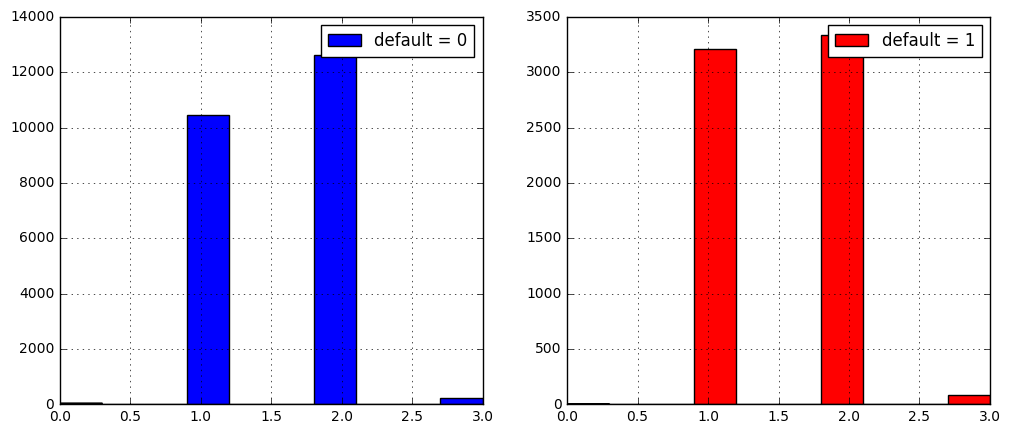

In [191]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
mar0.hist(label='default = 0')
pylab.legend()

pylab.subplot(1,2,2)
mar1.hist(color='red', label='default = 1')
pylab.legend()

In [185]:
Mar = np.array([[mar00, mar10, mar20, mar30],
                [mar01, mar11, mar21, mar31]])

In [186]:
chi2_contingency(Mar)

(35.662395834336088,
 8.8258624575773752e-08,
 3L,
 array([[  4.20552000e+01,   1.06376292e+04,   1.24327632e+04,
           2.51552400e+02],
        [  1.19448000e+01,   3.02137080e+03,   3.53123680e+03,
           7.14476000e+01]]))

In [188]:
VC_stat = np.sqrt(chi2_contingency(Mar)[0]/data.shape[0])
VC_stat

0.034478203662766466

Как видно из коэффициента Крамера взаимосвязи между признаками (замужеством и возвратом кредита) практически нет.

## Task 5

In [82]:
age0 = data[data['default']==0].AGE
age1 = data[data['default']==1].AGE

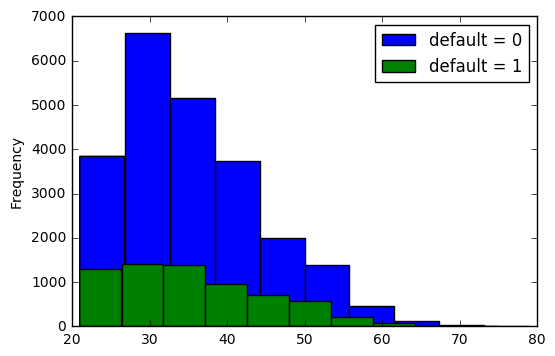

In [83]:
age0.plot.hist(label='default = 0')
age1.plot.hist(label='default = 1')
pylab.legend(loc='upper right')
pylab.show()

In [84]:
age0.describe()

count    23364.000000
mean        35.417266
std          9.077355
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

In [85]:
age1.describe()

count    6636.000000
mean       35.725738
std         9.693438
min        21.000000
25%        28.000000
50%        34.000000
75%        42.000000
max        75.000000
Name: AGE, dtype: float64

Проверим гипотезу о равенстве медиан двумя способами: 
        
       а) С помощью доверительного интервала для разности медиан
       б) С помощью непараметрического критерия проверки равенства средних

Построим доверительный интервал для разности медиан в двух выборках:

In [86]:
np.random.seed(0)

age0_median_scores = map(np.median, get_bootstrap_samples(age0.values, 1000))
age1_median_scores = map(np.median, get_bootstrap_samples(age1.values, 1000))

In [89]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(age0_median_scores, age1_median_scores))

In [96]:
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [ 0.  1.]


0 является нижней границей доверительного интервала, к тому же доверительный интервал довольно узкий, чтобы заключать, что медианы в двух группах людей отличаются.

Воспользуемся непараметрическим методом:

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [98]:
print "p-value: %f" % permutation_test(age0, age1, max_permutations = 10000)

p-value: 0.017700


p_value<0.05, следовательно нулевую гипотезу о равенстве распределений можно отвергнуть на уровне значимости 0.05 в пользу альтернативы. В данном случае практическая значимость невелика, так как на самом деле отличия в возрасте у людей в обоих группах невелики.